<a href="https://colab.research.google.com/github/rrwiren/ilmanlaatu-ennuste-helsinki/blob/main/Colab_Script_Helsinki_Kaisaniemi_Weather_Data_EDA_%26_Visualization_(v4_Lopullinen).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- Helsinki Kaisaniemi Weather Data EDA Script (v4) ---

--- 1. Loading Data & Initial Inspection ---
Attempting to load data from: https://raw.githubusercontent.com/rrwiren/ilmanlaatu-ennuste-helsinki/main/data/raw/Helsinki%20Kaisaniemi_%201.4.2020%20-%201.4.2025_d5590617-bf91-46c7-96f4-1fb70892265d.csv
Reading CSV using its header, comma separator, dot decimal, and UTF-8 encoding...
Successfully loaded data using inferred header and UTF-8.

--- Initial Data Inspection (Brief) ---
Columns Found:
['Havaintoasema', 'Vuosi', 'Kuukausi', 'Päivä', 'Aika [Paikallinen aika]', 'Lämpötilan keskiarvo [°C]', 'Keskituulen nopeus [m/s]', 'Tuulen suunnan keskiarvo [°]', 'Ilmanpaineen keskiarvo [hPa]']

--- 2. Cleaning and Preparing Data ---
Creating Timestamp column...
Timestamp column created successfully.
Converting weather columns to numeric...
Attempting numeric conversion for: ['Lämpötilan keskiarvo [°C]', 'Keskituulen nopeus [m/s]', 'Tuulen suunnan keskiarvo [°]', 'Ilmanpaineen keskiarvo [hP

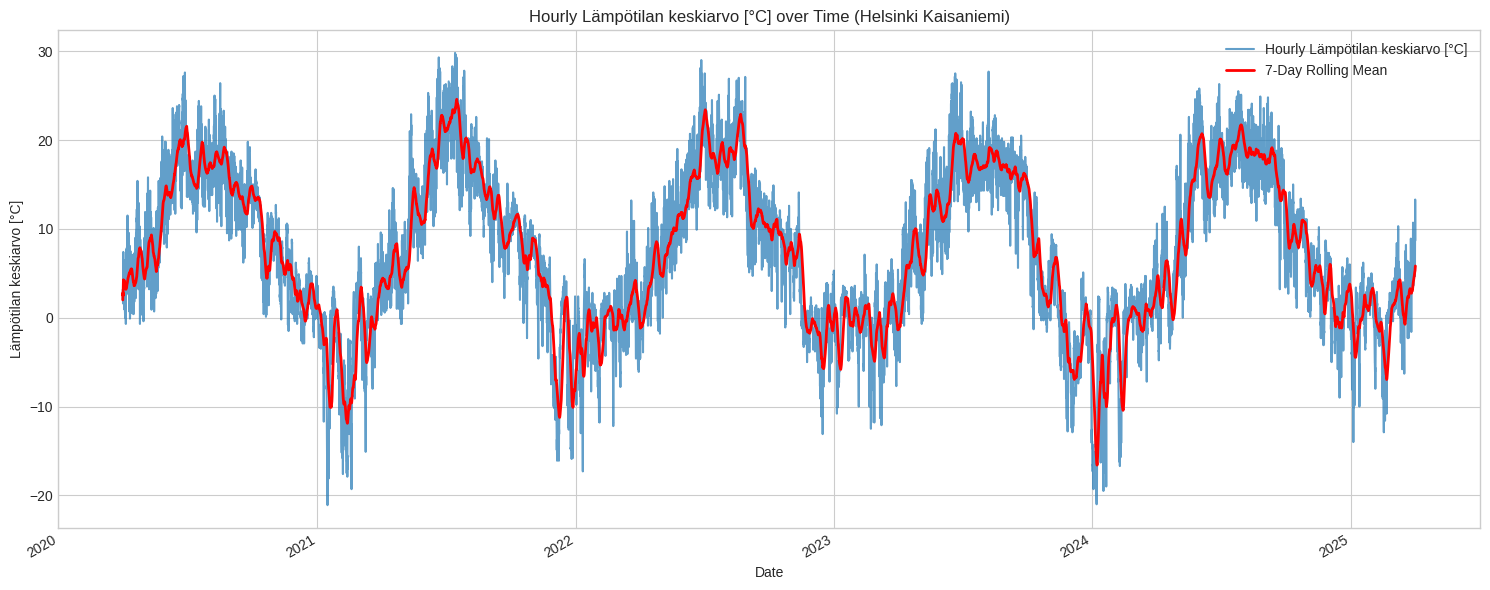

Time series plot generated.

Plotting distribution...


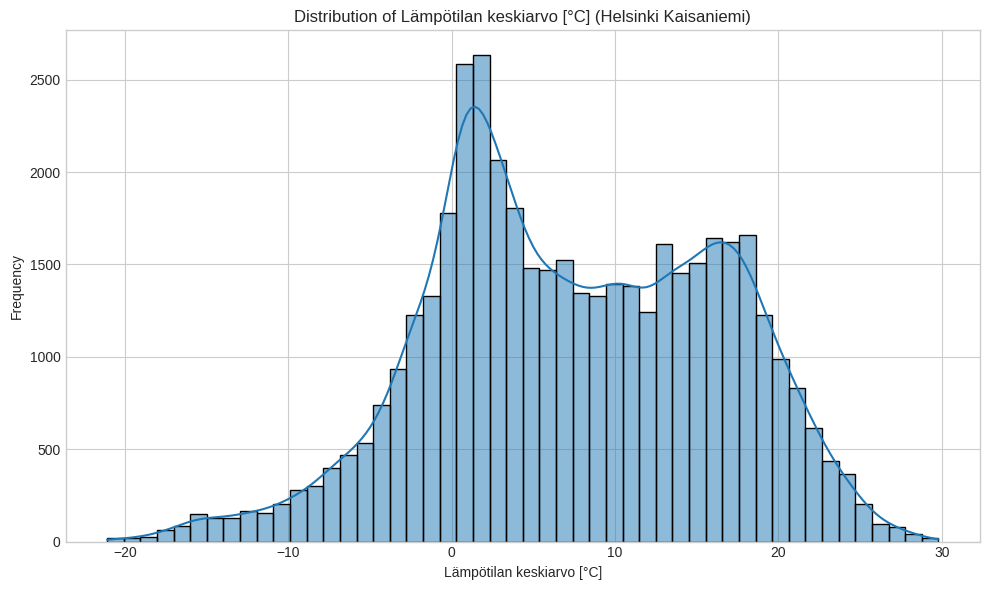

Distribution plot generated.

Plotting distribution by Year...


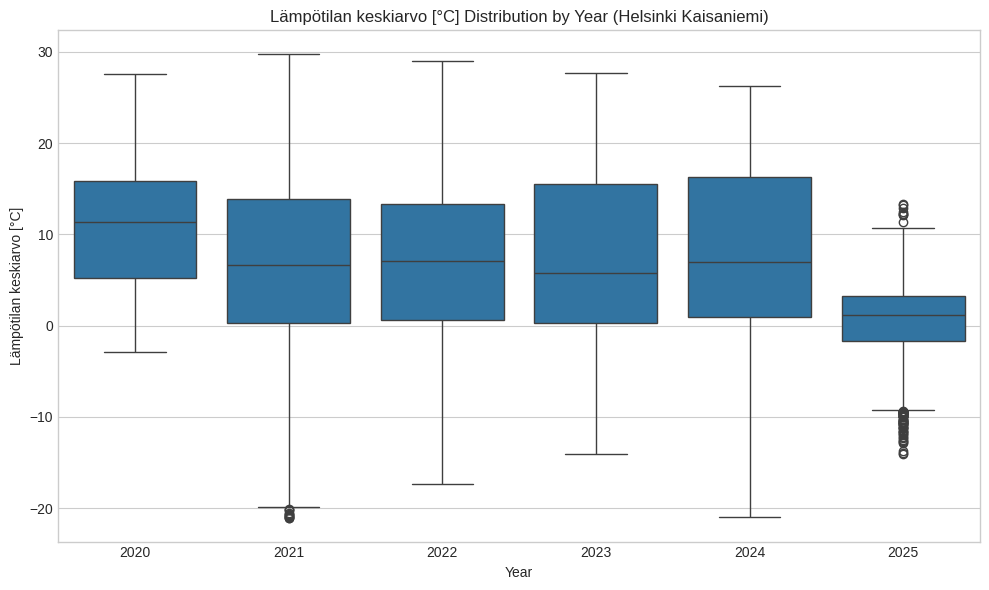

Box plot by year generated.

Plotting distribution by Month...


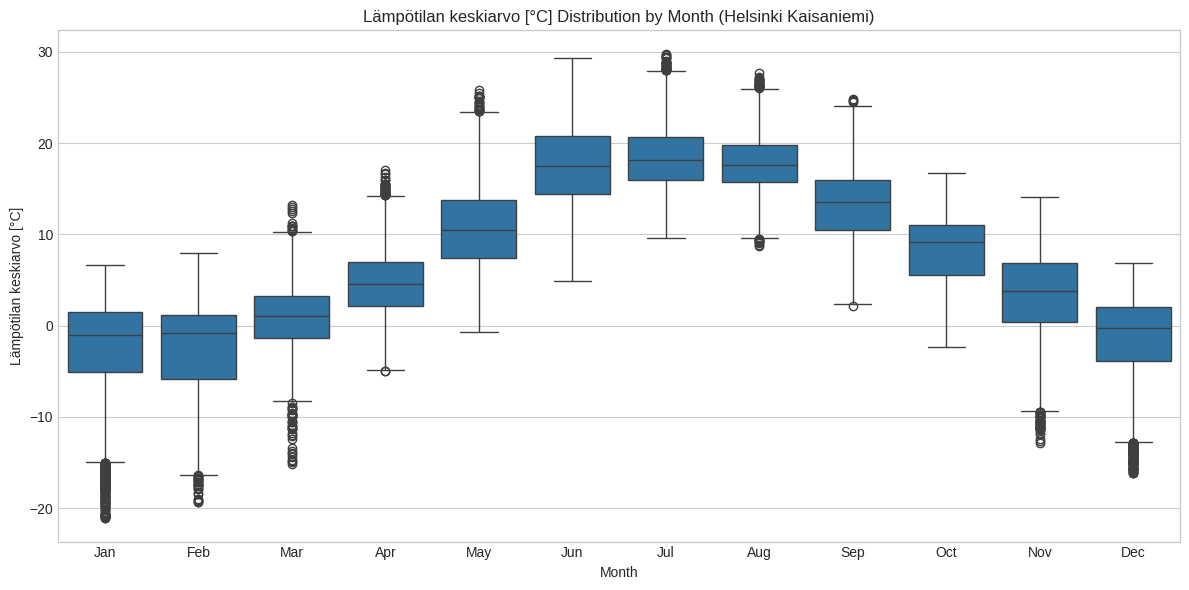

Box plot by month generated.

--- EDA Script Finished ---


In [1]:
# -*- coding: utf-8 -*-
"""
EDA Script for Helsinki Kaisaniemi Weather Data (for Google Colab) - v4

Loads weather data using correct encoding, cleans data, creates timestamp,
removes duplicate timestamps, performs basic EDA, and creates visualizations.
"""

# Import necessary libraries
import pandas as pd
import io
import requests
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import traceback # For error reporting

print("--- Helsinki Kaisaniemi Weather Data EDA Script (v4) ---")

# --- 1. Data Loading and Initial Inspection ---
print("\n--- 1. Loading Data & Initial Inspection ---")

# URL for Kaisaniemi data
raw_url = "https://raw.githubusercontent.com/rrwiren/ilmanlaatu-ennuste-helsinki/main/data/raw/Helsinki%20Kaisaniemi_%201.4.2020%20-%201.4.2025_d5590617-bf91-46c7-96f4-1fb70892265d.csv"
print(f"Attempting to load data from: {raw_url}")

df = None # Initialize df to None

try:
    # Fetch the content from the URL
    response = requests.get(raw_url)
    response.raise_for_status() # Raise an exception for bad status codes

    # Use UTF-8 encoding
    print("Reading CSV using its header, comma separator, dot decimal, and UTF-8 encoding...")
    csv_content = io.StringIO(response.content.decode('utf-8'))
    df = pd.read_csv(
        csv_content,
        sep=',',
        decimal='.',
        low_memory=False
    )
    print("Successfully loaded data using inferred header and UTF-8.")

    # Clean up potential extra spaces in column names
    df.columns = df.columns.str.strip()

    print("\n--- Initial Data Inspection (Brief) ---")
    print("Columns Found:")
    print(df.columns.tolist())

    # --- 2. Data Cleaning & Preparation ---
    print("\n--- 2. Cleaning and Preparing Data ---")

    # ** Identify Actual Date/Time Columns based on corrected names **
    year_col = 'Vuosi'
    month_col = 'Kuukausi'
    day_col = 'Päivä'
    time_col = 'Aika [Paikallinen aika]'

    required_dt_cols = [year_col, month_col, day_col, time_col]
    if not all(col in df.columns for col in required_dt_cols):
        print(f"Error: Missing one or more required date/time columns: {required_dt_cols}")
        raise ValueError("Missing date/time columns")

    # 2a. Create Timestamp column
    print("Creating Timestamp column...")
    try:
        df[year_col] = df[year_col].astype(str)
        df[month_col] = df[month_col].astype(str).str.zfill(2)
        df[day_col] = df[day_col].astype(str).str.zfill(2)
        df[time_col] = df[time_col].astype(str)
        time_str = df[time_col].str.replace('24:00', '00:00', regex=False)
        datetime_str = df[year_col] + '-' + df[month_col] + '-' + df[day_col] + ' ' + time_str
        df['Timestamp'] = pd.to_datetime(datetime_str, format='%Y-%m-%d %H:%M', errors='coerce')
        df.loc[df[time_col] == '24:00', 'Timestamp'] += pd.Timedelta(days=1)
        parsing_errors = df['Timestamp'].isnull().sum()
        if parsing_errors > 0:
            print(f"Warning: {parsing_errors} rows resulted in NaT during timestamp creation.")
        print("Timestamp column created successfully.")
    except Exception as e:
        print(f"Error creating timestamp column: {e}")
        df['Timestamp'] = pd.NaT

    # 2b. Convert relevant weather columns to numeric
    print("Converting weather columns to numeric...")
    known_non_numeric = [year_col, month_col, day_col, time_col, 'Havaintoasema', 'Timestamp']
    weather_cols_to_convert = [col for col in df.columns if col not in known_non_numeric]
    print(f"Attempting numeric conversion for: {weather_cols_to_convert}")
    for col in weather_cols_to_convert:
        if col in df.columns:
             initial_nulls = df[col].isnull().sum()
             df[col] = pd.to_numeric(df[col], errors='coerce')
             final_nulls = df[col].isnull().sum()
             new_nulls = final_nulls - initial_nulls
             if new_nulls > 0:
                  print(f"  - Converted '{col}': {new_nulls} new NaNs introduced (Total: {final_nulls}).")
    print("Numeric conversion finished.")

    # 2c. Set Timestamp as index
    print("Setting Timestamp as DataFrame index...")
    if 'Timestamp' in df.columns and not df['Timestamp'].isnull().all():
        initial_rows = len(df)
        df.dropna(subset=['Timestamp'], inplace=True)
        if len(df) < initial_rows:
            print(f"Dropped {initial_rows - len(df)} rows with invalid Timestamps.")

        df.set_index('Timestamp', inplace=True, drop=False) # Keep Timestamp column
        df.sort_index(inplace=True)
        print("Index set and sorted.")

        # Check and remove duplicate indices
        print("Checking for duplicate timestamps in index...")
        duplicates = df.index.duplicated(keep='first')
        num_duplicates = duplicates.sum()
        if num_duplicates > 0:
            print(f"Warning: Found and removing {num_duplicates} duplicate timestamp entries (keeping first occurrence).")
            df = df[~duplicates]
        else:
            print("No duplicate timestamps found.")

    else:
        print("Skipping index setting (Timestamp column missing or empty).")


    # --- 3. Basic Text EDA ---
    print("\n--- 3. Basic Exploratory Data Analysis (Text) ---")

    print("\n--- Data Info (Post-Cleaning & Deduplication) ---")
    df.info()

    print("\n--- Missing Value Counts (Post-Cleaning & Deduplication) ---")
    print(df.isnull().sum())

    print("\n--- Summary Statistics (Numeric Weather Columns) ---")
    numeric_weather_cols = [col for col in weather_cols_to_convert if col in df.columns and pd.api.types.is_numeric_dtype(df[col])]
    if numeric_weather_cols:
         print(df[numeric_weather_cols].describe())
    else:
         print("No numeric weather columns found to describe.")

    print("\n--- Summary Statistics (Other Columns) ---")
    other_cols = ['Havaintoasema', 'Vuosi', 'Kuukausi', 'Päivä', 'Aika [Paikallinen aika]', 'Timestamp']
    print(df[[col for col in other_cols if col in df.columns]].astype(str).describe(include='object'))

    # Describe Timestamp separately if it exists - *** REMOVED datetime_is_numeric ARGUMENT ***
    if 'Timestamp' in df.columns and not df['Timestamp'].isnull().all():
        print("\n--- Timestamp Summary ---")
        print(df['Timestamp'].describe()) # Default describe for datetime


    # --- 4. Basic Visualizations ---
    print("\n--- 4. Generating Visualizations ---")
    plt.style.use('seaborn-v0_8-whitegrid')

    # ** Choose Target Variable: Temperature **
    target_col_name = 'Lämpötilan keskiarvo [°C]'

    if target_col_name not in df.columns or not pd.api.types.is_numeric_dtype(df[target_col_name]):
         print(f"Error: Target column '{target_col_name}' not found or is not numeric. Cannot generate plots.")
         target_col_name = None

    # Check if index is a DatetimeIndex
    is_timestamp_index = isinstance(df.index, pd.DatetimeIndex)

    if target_col_name and is_timestamp_index:
        print(f"Generating plots for '{target_col_name}'...")

        # 4a. Time Series Plot
        print("Plotting time series...")
        try:
            plt.figure(figsize=(15, 6))
            df[target_col_name].plot(alpha=0.7, label=f'Hourly {target_col_name}')
            df[target_col_name].rolling('7D').mean().plot(label='7-Day Rolling Mean', color='red', linewidth=2)
            plt.title(f'Hourly {target_col_name} over Time (Helsinki Kaisaniemi)')
            plt.xlabel('Date')
            plt.ylabel(f'{target_col_name}')
            plt.legend()
            plt.tight_layout()
            plt.show()
            print("Time series plot generated.")
        except Exception as e:
            print(f"Error generating time series plot: {e}")

        # 4b. Distribution Plot
        print("\nPlotting distribution...")
        try:
            plt.figure(figsize=(10, 6))
            sns.histplot(df[target_col_name].dropna(), kde=True, bins=50)
            plt.title(f'Distribution of {target_col_name} (Helsinki Kaisaniemi)')
            plt.xlabel(f'{target_col_name}')
            plt.ylabel('Frequency')
            plt.tight_layout()
            plt.show()
            print("Distribution plot generated.")
        except Exception as e:
            print(f"Error generating distribution plot: {e}")

        # 4c. Box Plot by Year
        print("\nPlotting distribution by Year...")
        try:
            plt.figure(figsize=(10, 6))
            sns.boxplot(x=df.index.year, y=df[target_col_name])
            plt.title(f'{target_col_name} Distribution by Year (Helsinki Kaisaniemi)')
            plt.xlabel('Year')
            plt.ylabel(f'{target_col_name}')
            plt.tight_layout()
            plt.show()
            print("Box plot by year generated.")
        except Exception as e:
            print(f"Error generating box plot by year: {e}")

        # 4d. Box Plot by Month
        print("\nPlotting distribution by Month...")
        try:
            plt.figure(figsize=(12, 6))
            sns.boxplot(x=df.index.month, y=df[target_col_name])
            plt.title(f'{target_col_name} Distribution by Month (Helsinki Kaisaniemi)')
            plt.xlabel('Month')
            plt.ylabel(f'{target_col_name}')
            plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
            plt.tight_layout()
            plt.show()
            print("Box plot by month generated.")
        except Exception as e:
            print(f"Error generating box plot by month: {e}")
    elif not target_col_name:
         print("\nSkipping visualizations: Target column for plotting not available or not numeric.")
    elif not is_timestamp_index:
         print("\nSkipping visualizations: Timestamp index not set correctly or data empty.")


except requests.exceptions.RequestException as e:
    print(f"FATAL ERROR: Could not fetch data from URL. {e}")
except pd.errors.EmptyDataError:
    print("FATAL ERROR: The CSV file appears to be empty.")
except ImportError as e:
    print(f"FATAL ERROR: Missing required library. {e}")
except ValueError as ve:
     print(f"FATAL ERROR during setup: {ve}") # Catch specific errors like missing columns
except Exception as e:
    print(f"An unexpected FATAL error occurred: {e}")
    print("Traceback:")
    traceback.print_exc()
finally:
    # Check if df exists and is a DataFrame before printing finished message
    if 'df' in locals() and isinstance(df, pd.DataFrame):
         print("\n--- EDA Script Finished ---")
    else:
         print("\n--- EDA Script Finished with Errors (Dataframe not loaded/processed) ---")